Convert this talk to a HTML preserntation via  
`jupyter nbconvert talk.ipynb --to slides`

https://medium.com/@mjspeck/presenting-code-using-jupyter-notebook-slides-a8a3c3b59d67

In [1]:
# Import packages, prepare data
# (TODO paste the file in here later again. I just don't like scrolling all the time while drafting this notebook)

%run setup.py

![title](img/title.jpg)

- Twitter: @eng_elhardt
- Slides: https://github.com/AlexEngelhardt/iml-talk
- Longer blog post available at https://www.alpha-epsilon.de/blog/

## Outline

- Intro: Problems in ML models
- Interpretable Machine Learning (IML)
- How to achieve interpretability
  - 1: Use interpretable models
  - 2: Post-hoc model-agnostic methods
- Data & Model
- Model-agnostic methods
  - Permutation Feature Importance
  - Partial Dependence Plots
  - Shapley values / SHAP
- Honorable mention: Adversarial Examples
- The future of IML

# Problems in ML models

- We like automatization
- ML models automatize easy decisions
- $\Rightarrow$ we like ML


- But: Black-box models come with a few problems

### Problem 1: Fairness

- October 2018: report about Amazon AI recruiting tool that favored men
- Amazon's model has built rules that penalized resumes that included the word "women's"


Report: https://www.theguardian.com/technology/2018/oct/10/amazon-hiring-ai-gender-bias-recruiting-engine  
Story source: https://appsilon.com/please-explain-black-box/

### Problem 2: Understanding

- Scientific disciplines (e.g biology) use more and more ML for producing scientific outcomes
- Their ultimate goal is not a correct model, but *knowledge*
- IML extracts knowledge from a trained model

- A 98% accurate Random Forest is no good if we can't extract an explanation from the model

### Problem 3: Explainability and Debugging

- February 2019: Polish amendment to a banking law; consequence of implementing GDPR in EU.
  - "[the data subject should have] the right ... to obtain an explanation of the decision reached". 
- gives a customer a right to receive an explanation in case of a negative credit decision.

----

- Interpretable models can be better audited and debugged, and better feature engineering is possible

<img src="img/husky-vs-wolf-LIME-paper.png" style="height: 200px" />

- "Why does my model misclassify all <18 year olds?"
- Solution in example: Get more pictures from Huskys in Alaska

# Lesson

- We need to be able to look under the hood of ML models and *understand* their behavior.
- This talk aims to be an introduction into the field and its methods.

- Because our loss function is often just one part of what we really want to optimize¹. Additional criteria that are not covered by the loss function:
  - fairness, explainability (as mentioned before),
    - This might also increase social acceptance of AI models
  - but also safety: You want to be 100% certain the abstraction for "cyclist" a DL driving model learned is correct. Imagine the model learned to "see" two wheels, then you'd run over bikes with side bags.
  
- These criteria often cannot be quantified. E.g. we can't enumerate and write all unit tests required to let an autonomous car drive completely safely.
- Interpretability is a popular fallback: If the system can /explain/ its reasoning, we can verify whether that reasoning makes sense with respect to these auxiliary criteria.

  
¹ Doshi-Velez et al., 2017

# Interpretable Machine Learning (IML) / Explainable AI (XAI)

> "Interpretability is the degree to which a human can understand the cause of a decision"
>
> -- Miller, Tim. "Explanation in artificial intelligence: Insights from the social sciences." [arXiv:1706.07269](https://arxiv.org/abs/1706.07269)

- A relatively young field, changes quickly
- Research papers appear at high speed
- Theory and terminology is diverse and not yet unified

# Interpretable Machine Learning

- This talk is based on Christoph Molnar's book *Interpretable Machine Learning*
- Available free at https://christophm.github.io/interpretable-ml-book/
- R-package [iml](https://cran.r-project.org/web/packages/iml/index.html)
  - A port to Python would be great!

<img src="img/iml-book.jpg" style="height: 250px" />

# How to achieve interpretability

- Option 1: Use interpretable models
- Option 2: Use black-box models and post-hoc interpretation methods

# Option 1: Use interpretable models

- Linear regression
  - Always a nice first choice
- Decision trees
  - good when nonlinear effects and interactions

----

- Simple models (like t-tests or regression) were okay in the 80s with small medical datasets
- They are simple beause they're heavily constrained
- Restrictive, unrealistic assumptions make them inflexible
- Underperformance gets worse for bigger datasets

- "heavily constrained": Either to linear relationships (like LM) or to monotonous relationships (like logistic regression; they make it easier to understand a relationship)

# Option 2: Use black-box models and post-hoc interpretation methods

- "Black Box" informally: A model that cannot be understood by looking at its parameters.
  - Linear Model vs. Neural Network
  
![Cypher](img/matrix.jpg)

# Model-agnostic Interpretation Methods

- We'll focus on model-agnostic methods
  - First train the model, then use a separate method to interpret the model
- Model-agnostic methods have a few advantages¹. They are flexible regarding:
  - models
  - explanations
  - representations
- Basic idea: Wiggle the input data and measure changes in the predicted output
  
¹ Ribeiro 2016

- Model-agnostic methods have a few advantages:
  - Flexible regarding models: You can use any model "below" it, as complex as you want.
	- You can replace the ML model anytime (low switching cost), and can compare different models in terms of interpretability. Before, you might have had a unwanted multi-objective optimization between a model that performs better but is less interpretable, and another that performed worse but is better interpretable. Those times are gone!
  - Flexible regarding explanations: Different model users might care about different explanations (e.g. ML engineers: feature importance vs. legal dept: feature effects vs. customers: What affected their own single prediction?).
  - Flexible regarding feature representations: You can swap out the features between training and interpreting: Train your document classifier with word embeddings, but explain its prediction using a RuleFit algorithm on the actual (interpretable) words.

# Interpretation Methods

- As always, the answer to "which method?" is "it depends"
- What do you want to understand?
  - The *global* model behavior, or a *single* data instance and why a specific prediction was made?
  - The *importance* of a feature, or the *effect size* of a feature?

----

- Global methods that explain global model behavior across all data instances
  - **1 - Permutation Feature Importance**
	- feature importance
  - **2 - Partial Dependence Plots**
    - feature effect
- Local methods that explain invididual predictions
  - **3 - Shapley Values**
	- feature effect

# Data

- [Bike sharing!](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)
- aggregated to daily averages (sums for the `count` variable)

In [2]:
data.sample(3)

,season,year,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
days_since_start,,,,,,,,,,,
304,winter,2011,no,tuesday,yes,clear,7.6,3.9,68.4,9.1,4068
306,winter,2011,no,thursday,yes,clear,7.9,4.3,70.2,9.2,3974
380,spring,2012,yes,monday,no,clear,-0.6,-6.5,52.2,15.5,2298


We recode factors into dummy variables:

In [3]:
dummy_data.sample(3)

,year,temp,feel_temp,humidity,windspeed,count,season_autumn,season_spring,season_summer,season_winter,...,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,workingday_no,workingday_yes,weather_clear,weather_light rain,weather_mist
days_since_start,,,,,,,,,,,,,,,,,,,,,
454,2012,6.4,2.8,58.1,9.3,5459,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
471,2012,17.9,14.7,56.2,19.1,6370,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
555,2012,19.7,16.7,68.3,12.1,6569,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


# Models

- A linear model
- A random forest

In [4]:
X = dummy_data.drop('count', axis=1)
y = dummy_data['count']

rf_mod = RandomForestRegressor(n_estimators=100)
rf_mod.fit(X, y)

lm_mod = LinearRegression()
lm_mod.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [5]:
print('LM:', mean_absolute_error(y, lm_mod.predict(X)))
print('RF:', mean_absolute_error(y, rf_mod.predict(X)))

LM: 577.064364441647
RF: 175.78575923392611


# 1 - Permutation Feature Importance

- Model-agnostic version of linear model's **standardized feature coefficient** (or: p-value) 
- Measures the *importance* of a single feature for the predicted outcome
- Automatically captures interaction effects/importance too
- First described in Breiman's 2001 Random Forest paper
- Algorithm:
  1. Shuffle the column of interest
  2. Predict with true data
  3. Predict with shuffled data
    - /* No retraining of the model necessary! */
  4. Take difference between losses
  5. Compute pointwise average

In [6]:
import eli5
from eli5.sklearn import PermutationImportance

In [7]:
# Ideally you'd compute feature importance on test data

rf_perm = PermutationImportance(rf_mod).fit(X, y)

eli5.show_weights(rf_perm, top=10, feature_names=list(X.columns))

Weight,Feature
0.5875 ± 0.0366,year
0.4078 ± 0.0244,temp
0.1055 ± 0.0096,humidity
0.0853 ± 0.0067,feel_temp
0.0601 ± 0.0101,season_spring
0.0427 ± 0.0073,weather_light rain
0.0410 ± 0.0060,windspeed
0.0395 ± 0.0086,season_winter
0.0076 ± 0.0007,weather_clear
0.0052 ± 0.0008,season_summer


### Recall problem 1: Fairness

- PFI handle this problem because now you see how much each feature (e.g. gender) contributes to the predictions

### Problem 1: Fairness

- October 2018: report about Amazon AI recruiting tool that favored men
- Amazon's model has built rules that penalized resumes that included the word "women's"

# 2 - Partial Dependence Plots

- Model-agnostic version of linear model's **feature coefficient** 
- Measures the *effect* of a single feature on the predicted outcome
- First described in Friedman's 2001 Gradient Boosting Machine paper
- Algorithm (for categorical variables - most intuitive, for the beginning):
  - For each feature value (e.g. spring, summer, autumn, winter):
    - Force the entire dataset's `season` to this feature value (e.g. winter)
    - Keep all other features the same
    - Predict $\hat{y}$
    - Average the predictions

In [8]:
from sklearn.inspection import partial_dependence, plot_partial_dependence  # needs sklearn >=0.21

seasons = ['season_spring', 'season_summer', 'season_autumn', 'season_winter']
PDs = pd.Series(np.nan, index=seasons)
for season in seasons:
    X_temp = X.copy()
    for S in seasons:
        X_temp[S] = 0
    X_temp[season] = 1
    PDs[season] = rf_mod.predict(X_temp).mean()

In [9]:
# PD on 'season', *given* everything else (e.g. temperature) stays the same:
PDs

season_spring    4034.640315
season_summer    4518.235869
season_autumn    4592.012134
season_winter    4907.473037
dtype: float64

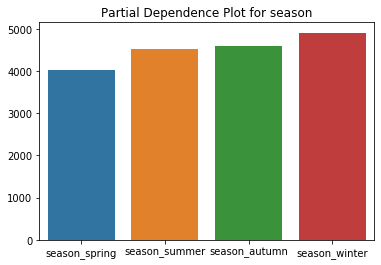

In [10]:
ax = sns.barplot(x=PDs.index, y=PDs)
_ = ax.set_title('Partial Dependence Plot for season')

# PDPs of a linear model

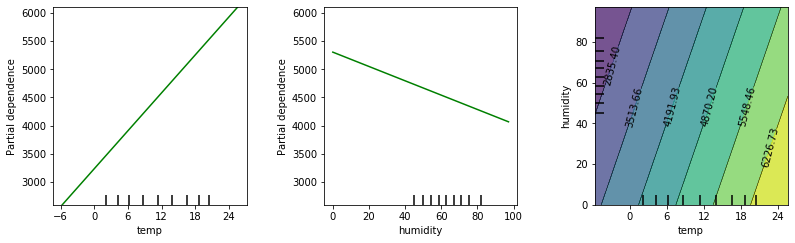

In [11]:
# small vertical lines are the data's deciles

fig, ax = plt.subplots(1, 3, figsize=(12,5))

plot_partial_dependence(lm_mod, X, features=[1, 3, (1, 3)],
                       grid_resolution=25, percentiles=(0, 1), n_jobs=4,
                       feature_names=X.columns, fig=fig)

Here you see the main problem in linear models: They assume a linear relationship with temperature.

- 5°C: 4'000 bikes
- 10°C: 4'500 bikes
- $\Rightarrow$ 50°C: 15'000 bikes!


# PDPs of a Random Forest

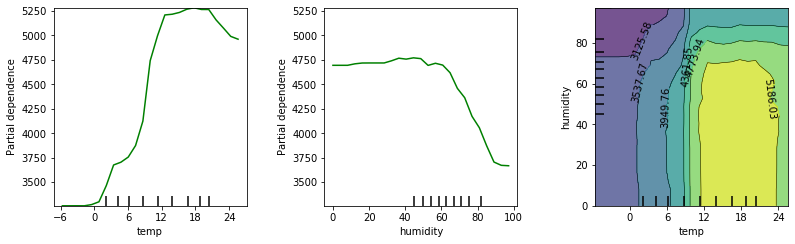

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12,5))


plot_partial_dependence(rf_mod, X, features=[1, 3, (1, 3)],
                       grid_resolution=25, percentiles=(0, 1), n_jobs=4,
                       feature_names=X.columns, fig=fig)

### Recall problem 2: Understanding

PDPs are one solution to this problem because we obtain the marginalized feature effect for each feature.

### Problem 2: Understanding

- Scientific disciplines (e.g biology) use more and more ML for producing scientific outcomes
- Their ultimate goal is not a correct model, but *knowledge*
- A 98% accurate Random Forest is no good if we can't extract an explanation from the model
- IML extracts knowledge from a trained model
- Solution: PDPs

# 3 - Shapley Values / SHAP

- How much does each feature contribute?
- "How to fairly distribute the prediction among the features?" 
- For linear models, each feature's contribution is easy: $\beta_j \cdot x_j$
- Example: 
  - Predict the sale price of an apartment
    - 64 sq.m.
    - 5th floor
    - does not allow pets
    - has one balcony
  - $\hat{y}$ = 320'000€.
  - How did each feature influence the prediction? Maybe:
    - Average prediction is 300'000€.
    - 64sq.m. $\Rightarrow$ + 15'000€
    - balcony $\Rightarrow$ + 7'000€
    - no-cats-allowed $\Rightarrow$ - 2'000€.

# 3 - Shapley Values / SHAP

- Based on game theory:
  - The "game" is the prediction task for one single instance
  - The "gain" is the actual prediction minus the average prediction of all instances.
  - The "players" are the feature values that collaborate to receive the gain (= predict a certain value)
  - Features act as a coalition
  - Shapley value: assign payouts to players depending on their contribution to the total payout

https://christophm.github.io/interpretable-ml-book/shap.html  
https://github.com/slundberg/shap

- Computing Shapley values is a bit complex. Here: only the intuition

In [13]:
import shap

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(rf_mod)

# Compute for only 100 observations to save computing time
X_sub = X.sample(100, random_state=20190818)

shap_values = explainer.shap_values(X_sub)  # takes long

# load JS visualization code to notebook
shap.initjs()

# Shapley Values

- Visualize Shapley Values as *forces*
- The Shapley values are *additive* importance measures
- They move the prediction away from the *base value* (the average prediction over all instances)

In [14]:
shap.force_plot(explainer.expected_value, shap_values[20,:], X_sub.iloc[20,:])

> "Why didn't we make any revenue on this day? It was a perfect 15°C!"
>
> "Yes, the temperature on that day was good for bike rentals, but that effect 
> was nullified again by the high humidity"

- There are many other cool measures and plots based on Shapley values
- Once you understand them, you can use the principle for your entire interpretability suite!

# Shapley-based feature importance

- Simple measure of feature importance
- The average *absolute* Shapley value for each feature

----

- Alternative to permutation feature importance discussed earlier
- But: There is a big difference between both importance measures: Permutation feature importance is based on the decrease in model performance. SHAP is based on magnitude of feature attributions.
  - https://christophm.github.io/interpretable-ml-book/shap.html#shap-feature-importance

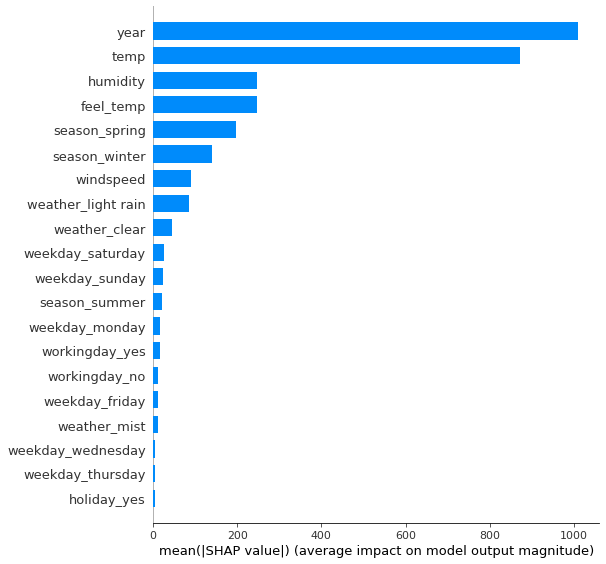

In [15]:
shap.summary_plot(shap_values, X_sub, plot_type="bar")

# SHAP dependence plot

SHAP feature dependence might be the simplest global interpretation plot: 

1. Pick a feature.
2. For each data instance, plot a point with the feature value on the x-axis and the corresponding Shapley value on the y-axis.

----

- Alternative to partial dependence plots discussed earlier. 
- But: PDP shows average effects, SHAP dependence also shows the variance on the y-axis
- Especially if there are interactions, the SHAP dependence plot will be much more dispersed in the y-axis. 

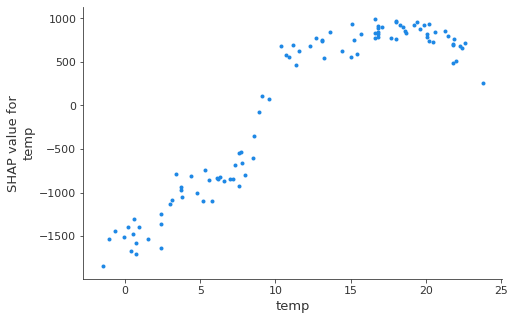

In [16]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("temp", shap_values, X_sub, interaction_index=None)

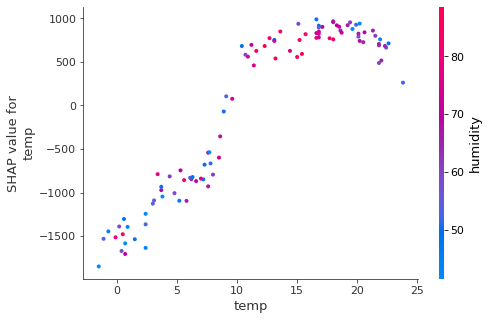

In [17]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("temp", shap_values, X_sub, interaction_index='humidity')

### Recall problem 3: Explainability

- Shapley Values solve this problem because now you can visualize the size of each feature that contributed to a loan being rejected.


### Problem 3: Explainability and Debugging

- February 2019: Polish amendment to a banking law; consequence of implementing GDPR in EU.
  - GDPR quote: "[the data subject should have] the right ... to obtain an explanation of the decision reached". 
- gives a customer a right to receive an explanation in case of a negative credit decision.

----

- Interpretable models can be better audited and debugged, and better feature engineering is possible

<img src="img/husky-vs-wolf-LIME-paper.png" style="height: 200px" />

- Solution: Local methods, such as Shapley Values / SHAP

# Honorable mention: Adversarial Examples

An [adversarial example](https://christophm.github.io/interpretable-ml-book/adversarial.html) is an (artificial) instance with small changes in the features, that trick the model into making a false prediction.

![Adversarial Turtle](img/adversarial-turtle.jpg)

Source: Athalye 2017

Adversarial Turtle:

- Looks like a rifle from many angles and zoom levels.
- It's not a big leap now to design a rifle that gets classified as a turtle.
- Adversarial examples make the ML model vulnerable to attacks. 
  - If you know them, you can use them in an updated training set.
  - If your opponent knows them, he can get a loan, pass your gun detection AI, or make your car run over a stop sign (there are stickers for that)


# The Future of Interpretable Machine Learning

- ML will grow because it *automatizes* decision making
- IML helps:
  - to convince hesitant people or satisfy legal requirements
  - because we are never able to perfectly specify our goal to the computer
  - to understand the weaknesses in your models
- Model-agnostic methods are the most flexible
- Adversarial Machine Learning will be a new field in Cybersecurity. More ML models deployed IRL, more entry points for attacks¹.
	- IML as an "arms race" between attackers and defenders. Goal: be one step ahead of your competition.
- Like ML, IML will be automatized in the future

¹ Biggio 2018

- "because we are never able to perfectly specify our goal to the computer"
  - He stupidly does *exactly* what we tell him to.
  - You specify an imperfect or a proxy goal (e.g. corporation: maximize profit for shareholders), and the "system" (e.g. model) might find a solution you didn't want (e.g. through imperfect training data).
  - Think of a genie in a bottle that takes your wishes literally: “I want to be happy for the rest of my life!”, and the genie gives you a hit of heroin, then kills you.
- "Like ML, IML will be automatized in the future"
  - Like a test suite that runs after every code build, every retrained model gets an automatic report of feature importance, PDPs, a few surrogate models, etc.
  - We won't die out, though. Today anyone can build websites without HTML, CSS, JS, but we still need web developers. Tomorrow, anyone can train a ML model, but we'll still need ML experts.

![end](img/end.jpg)

- Twitter: @eng_elhardt
- Slides: https://github.com/AlexEngelhardt/iml-talk
- Longer blog post available at https://www.alpha-epsilon.de/blog/

# References

   - Molnar, Christoph. "Interpretable machine learning. A Guide for Making Black Box Models Explainable", 2019. https://christophm.github.io/interpretable-ml-book/.
   - Doshi-Velez, Finale, and Been Kim. “Towards a rigorous science of interpretable machine learning,” no. Ml: 1–13. http://arxiv.org/abs/1702.08608 (2017).
   - Ribeiro, Marco Tulio, Sameer Singh, and Carlos Guestrin. "Model-agnostic interpretability of machine learning." https://arxiv.org/pdf/1606.05386 (2016).
   - Biggio, Battista, and Fabio Roli. "Wild patterns: Ten years after the rise of adversarial machine learning." Pattern Recognition 84 (2018): 317-331. https://arxiv.org/pdf/1712.03141
   - Athalye, Anish, et al. "Synthesizing robust adversarial examples." https://arxiv.org/pdf/1707.07397.pdf (2017).

# Bonus Slides

### IML on training or test data?

- tl;dr: It depends on what you want to know
- Imagine an overfitted SVM with 100 garbage features.
  - What feature importance would you expect? 
    - Zero because the features are noise? $\Rightarrow$ use test data
    - Or should they reflect how much the model depends on each feature? $\Rightarrow$ use training data
- See also Molnar [chapter 5.5.2](https://christophm.github.io/interpretable-ml-book/feature-importance.html#feature-importance-data)   

# Bonus Slides

### Correlations in features

- If features are correlated, partial dependence plots will be computed with unrealistic instances
- e.g. `temp = 20` degrees, but `feel_temp = -5`

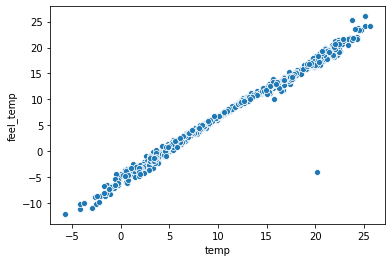

In [18]:
sns.scatterplot('temp', 'feel_temp', data=data)

- wat do?
- A method called *Accumulated Local Effects* (ALEs) is unbiased then
- See Molnar 2019

# Bonus slides


### Why are Partial Dependences so different from the group means?

- Here, we use *every* instance for every category
- Feature interactions are marginalized out:
  - Group means of `winter` contain only observations with -10°C
  - Manipulated data contains observations with +30°C and manipulated season `winter`
  - $\Rightarrow$ The *pure* effect of season is not so high

This becomes clear once we compute ICEs, i.e. a PDP for *one* observation:

In [19]:
# Compute group-by-season means of the predictions

data['yhat'] = rf_mod.predict(X)
print(data.groupby('season')['yhat'].mean())
data.drop('yhat', axis=1, inplace=True)

season
autumn    5633.747394
spring    2637.153757
summer    5019.563967
winter    4720.745056
Name: yhat, dtype: float64


In [20]:
i = 234
one_obs = X.iloc[i:(i+1), :]  # weird syntax keeps it a DF instead of a Series

one_obs

,year,temp,feel_temp,humidity,windspeed,season_autumn,season_spring,season_summer,season_winter,holiday_no,...,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,workingday_no,workingday_yes,weather_clear,weather_light rain,weather_mist
days_since_start,,,,,,,,,,,,,,,,,,,,,
234,2011,17.0,14.3,45.5,9.8,1,0,0,0,1,...,0,0,0,1,0,0,1,1,0,0


In [21]:
seasons = ['season_spring', 'season_summer', 'season_autumn', 'season_winter']
PDs = pd.Series(np.nan, index=seasons)
for season in seasons:
    one_obs_temp = one_obs.copy()
    for S in seasons:
        one_obs_temp[S] = 0
    one_obs_temp[season] = 1
    PDs[season] = rf_mod.predict(one_obs_temp).mean()

# PD on 'season', *given* everything else (e.g. temperature) stays the same:
PDs

season_spring    4810.74
season_summer    5500.55
season_autumn    5573.21
season_winter    5543.49
dtype: float64